# Pivot Point

## Import Library

In [12]:
import sys
sys.path.append('../../')

In [13]:
from config.constants import *
from backtesting import Backtest 
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Pivot_Point import Pivot_Point, PrepareData
from Pivot_PointV2 import Pivot_PointV2, PrepareDataV2
from util.Save_result_return import save_to_csv

## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = Pivot_Point

In [6]:
account_size = 20000

## Prepare Data

In [7]:
data_D1 = PrepareData(XAUUSD['D1'])
data_H4 = PrepareData(XAUUSD['H4'])
data_H1 = PrepareData(XAUUSD['H1'])
data_M30 = PrepareData(XAUUSD['M30'])
data_M15 = PrepareData(XAUUSD['M15'])
data_M5 = PrepareData(XAUUSD['M5'])
data_M1 = PrepareData(XAUUSD['M1'])

In [7]:
data_H4 = PrepareData(XAUUSD['H4'])

# Backtest each time frame

## TF D1

In [8]:
Backtest_D1 = Backtest(data_D1, strategy, cash=account_size, margin=1/2000, )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 16:00:00
End                       2023-03-10 00:00:00
Duration                   5911 days 08:00:00
Exposure Time [%]                    99.97025
Equity Final [$]                    19464.729
Equity Peak [$]                     21795.822
Return [%]                          -2.676355
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.168028
Volatility (Ann.) [%]                3.829592
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.972111
Avg. Drawdown [%]                   -0.899529
Max. Drawdown Duration     4203 days 08:00:00
Avg. Drawdown Duration      119 days 15:00:00
# Trades                                 6054
Win Rate [%]                        43.657086
Best Trade [%]                      11.735448
Worst Trade [%]                     -9.290183
Avg. Trade [%]                    

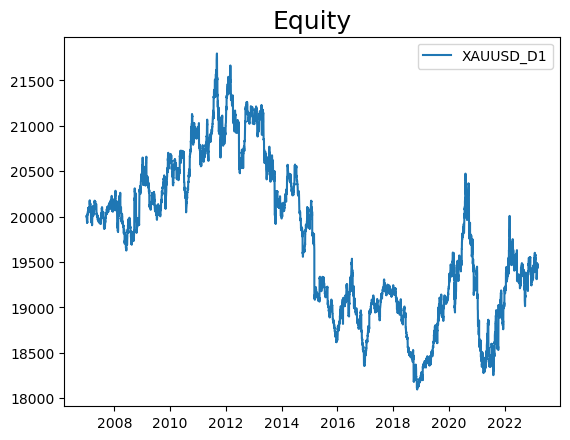

In [11]:
plot_equity_trades(result_D1['_equity_curve'], 'XAUUSD_D1' , account_size)

### Save output

In [12]:
# save_to_csv(result_D1, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_D1.csv')  

In [20]:
from backtesting import Strategy
import numpy as np
import pandas as pd
from util.ATR import *
from util.SMA import *
from util.Bollinger_bands import *
from util.load_data import *


def PrepareDataV2(data):
    agg_dict = {"Open": "first",
                "High": "max",
                "Low": "min",
                "Close": "last"
                }
    daily_data = data.resample("D", offset="16H").agg(agg_dict).dropna()
    daily_data.columns = ["Open_d", "High_d", "Low_d", "Close_d"]
    data = pd.concat([data, daily_data.shift().dropna()],
                     axis=1).ffill().dropna()
    return data


class Pivot_PointV2(Strategy):
    periods = 14
    moving_av = 3

    def init(self):

        self.data.df["PP"] = (
            self.data.df["High_d"] + self.data.df["Low_d"] + self.data.df["Close_d"]) / 3
        self.data.df["S1"] = self.data.df["PP"] * 2 - self.data.df["High_d"]
        self.data.df["S2"] = self.data.df["PP"] - \
            (self.data.df["PP"] - self.data.df["PP"])
        self.data.df["R1"] = self.data.df["PP"] * 2 - self.data.df["Low_d"]
        self.data.df["R2"] = self.data.df["PP"] + \
            (self.data.df["High_d"] - self.data.df["Low_d"])

        self.data.df["position"] = np.where(
            self.data.df["Open"] > self.data.df["PP"], 1, -1)
        self.data.df["position"] = np.where(
            self.data.df["Open"] >= self.data.df["R1"], 0, self.data.df["position"])
        self.data.df["position"] = np.where(
            self.data.df["Open"] <= self.data.df["S1"], 0, self.data.df["position"])

    def next(self):
        position = self.data.df.loc[self.data.df.index[-1], 'position']
        if position == 1:
            if self.position.is_short:
                self.position.close()
            self.buy(size=1)
        if position == 0:
            if self.position.is_long:
                self.position.close()
            self.sell(size=1)

In [21]:
data_H4_V2 = PrepareDataV2(XAUUSD['H4'])

In [22]:
strategyV2 = Pivot_PointV2

In [23]:
Backtest_H4_V2 = Backtest(data_H4_V2, strategyV2,
                       cash=account_size, margin=1/2000, )
result_H4_V2 = Backtest_H4_V2.run()
result_H4_V2

Start                     2007-01-01 16:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.992545
Equity Final [$]                    27088.616
Equity Peak [$]                     28169.119
Return [%]                           35.44308
Buy & Hold Return [%]              193.102239
Return (Ann.) [%]                    1.526944
Volatility (Ann.) [%]                5.181565
Sharpe Ratio                         0.294688
Sortino Ratio                         0.41758
Calmar Ratio                         0.089264
Max. Drawdown [%]                  -17.105966
Avg. Drawdown [%]                   -0.766901
Max. Drawdown Duration     1715 days 20:00:00
Avg. Drawdown Duration       39 days 11:00:00
# Trades                                16576
Win Rate [%]                        50.639479
Best Trade [%]                      10.768562
Worst Trade [%]                     -9.050228
Avg. Trade [%]                    

## TF H4

In [8]:
Backtest_H4 = Backtest(data_H4, strategy,
                       cash=100, margin=1/100 )
result_H4 = Backtest_H4.run()
result_H4

C:\Users\Win10\AppData\Local\Temp\ipykernel_4480\2575195766.py:1: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  Backtest_H4 = Backtest(data_H4, strategy,


Start                     2007-01-01 16:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.992545
Equity Final [$]                    14302.886
Equity Peak [$]                     14302.886
Return [%]                          14202.886
Buy & Hold Return [%]              193.102239
Return (Ann.) [%]                   28.133997
Volatility (Ann.) [%]               47.765079
Sharpe Ratio                         0.589008
Sortino Ratio                        1.600739
Calmar Ratio                         0.658028
Max. Drawdown [%]                  -42.755044
Avg. Drawdown [%]                   -3.173107
Max. Drawdown Duration     1463 days 16:00:00
Avg. Drawdown Duration       22 days 07:00:00
# Trades                                16576
Win Rate [%]                        52.431226
Best Trade [%]                      12.298778
Worst Trade [%]                     -7.257647
Avg. Trade [%]                    

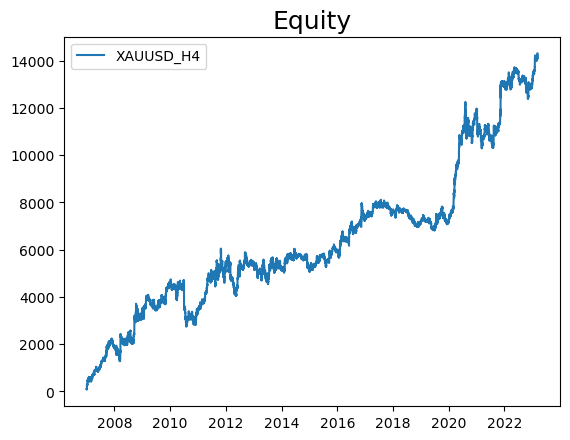

In [10]:
plot_equity_trades(result_H4['_equity_curve'], 'XAUUSD_H4', account_size)

### Save output

In [14]:
# save_to_csv(result_H4, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_H4.csv')  

## TF H1

In [15]:
Backtest_H1 = Backtest(data_H1, strategy,
                       cash=account_size, margin=1/2000, )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 16:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 01:00:00
Exposure Time [%]                   99.997976
Equity Final [$]                    39727.532
Equity Peak [$]                     39727.532
Return [%]                           98.63766
Buy & Hold Return [%]              193.053396
Return (Ann.) [%]                    3.487364
Volatility (Ann.) [%]                9.420214
Sharpe Ratio                           0.3702
Sortino Ratio                        0.565052
Calmar Ratio                         0.180726
Max. Drawdown [%]                  -19.296386
Avg. Drawdown [%]                   -0.721635
Max. Drawdown Duration     3220 days 22:00:00
Avg. Drawdown Duration       21 days 08:00:00
# Trades                                62679
Win Rate [%]                        53.703792
Best Trade [%]                      10.996822
Worst Trade [%]                     -7.377338
Avg. Trade [%]                    

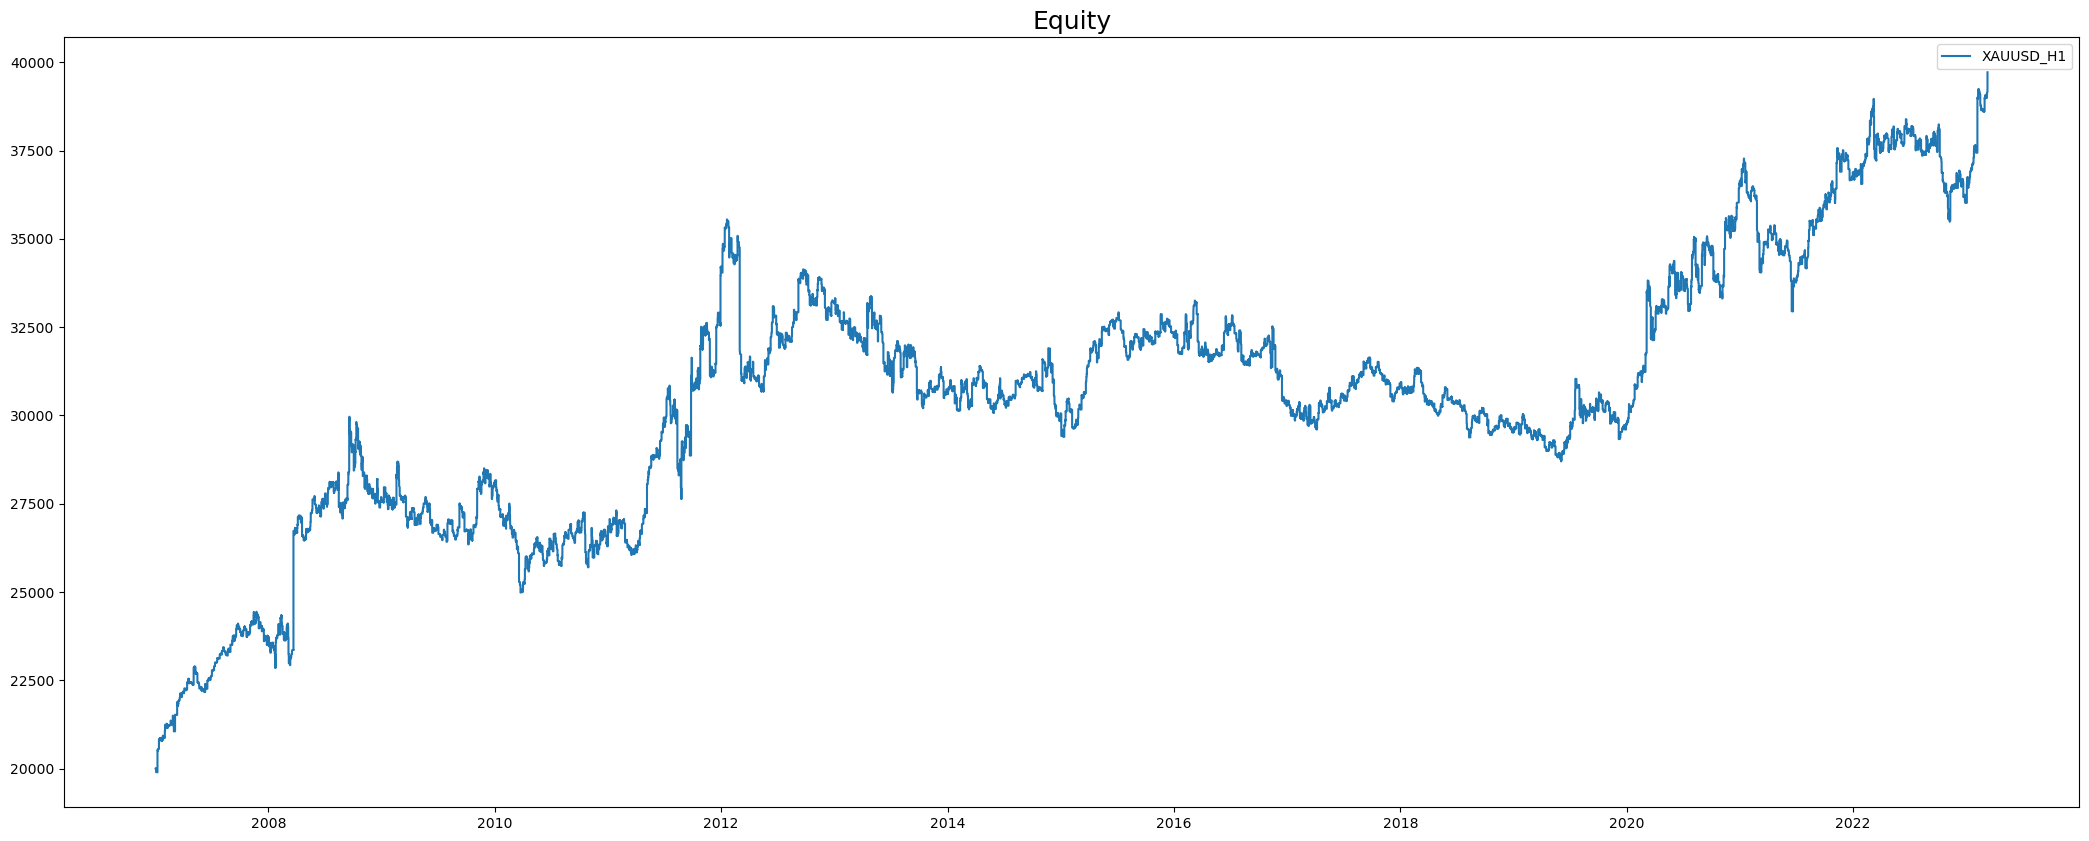

In [16]:
plot_equity_trades(result_H1['_trades'], 'XAUUSD_H1', account_size)

### Save output

In [17]:
# save_to_csv(result_H1, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_H1.csv')  

## TF M30 

In [8]:
Backtest_M30 = Backtest(data_M30, strategy,
                       cash=account_size, margin=1/2000, )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 16:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 01:30:00
Exposure Time [%]                    99.99898
Equity Final [$]                    44399.758
Equity Peak [$]                     44399.758
Return [%]                          121.99879
Buy & Hold Return [%]               193.27378
Return (Ann.) [%]                    4.063503
Volatility (Ann.) [%]               17.326104
Sharpe Ratio                         0.234531
Sortino Ratio                        0.348685
Calmar Ratio                         0.077309
Max. Drawdown [%]                  -52.562005
Avg. Drawdown [%]                   -0.798417
Max. Drawdown Duration     4053 days 05:00:00
Avg. Drawdown Duration       15 days 02:24:00
# Trades                               125331
Win Rate [%]                        54.980013
Best Trade [%]                       7.951129
Worst Trade [%]                      -7.80477
Avg. Trade [%]                    

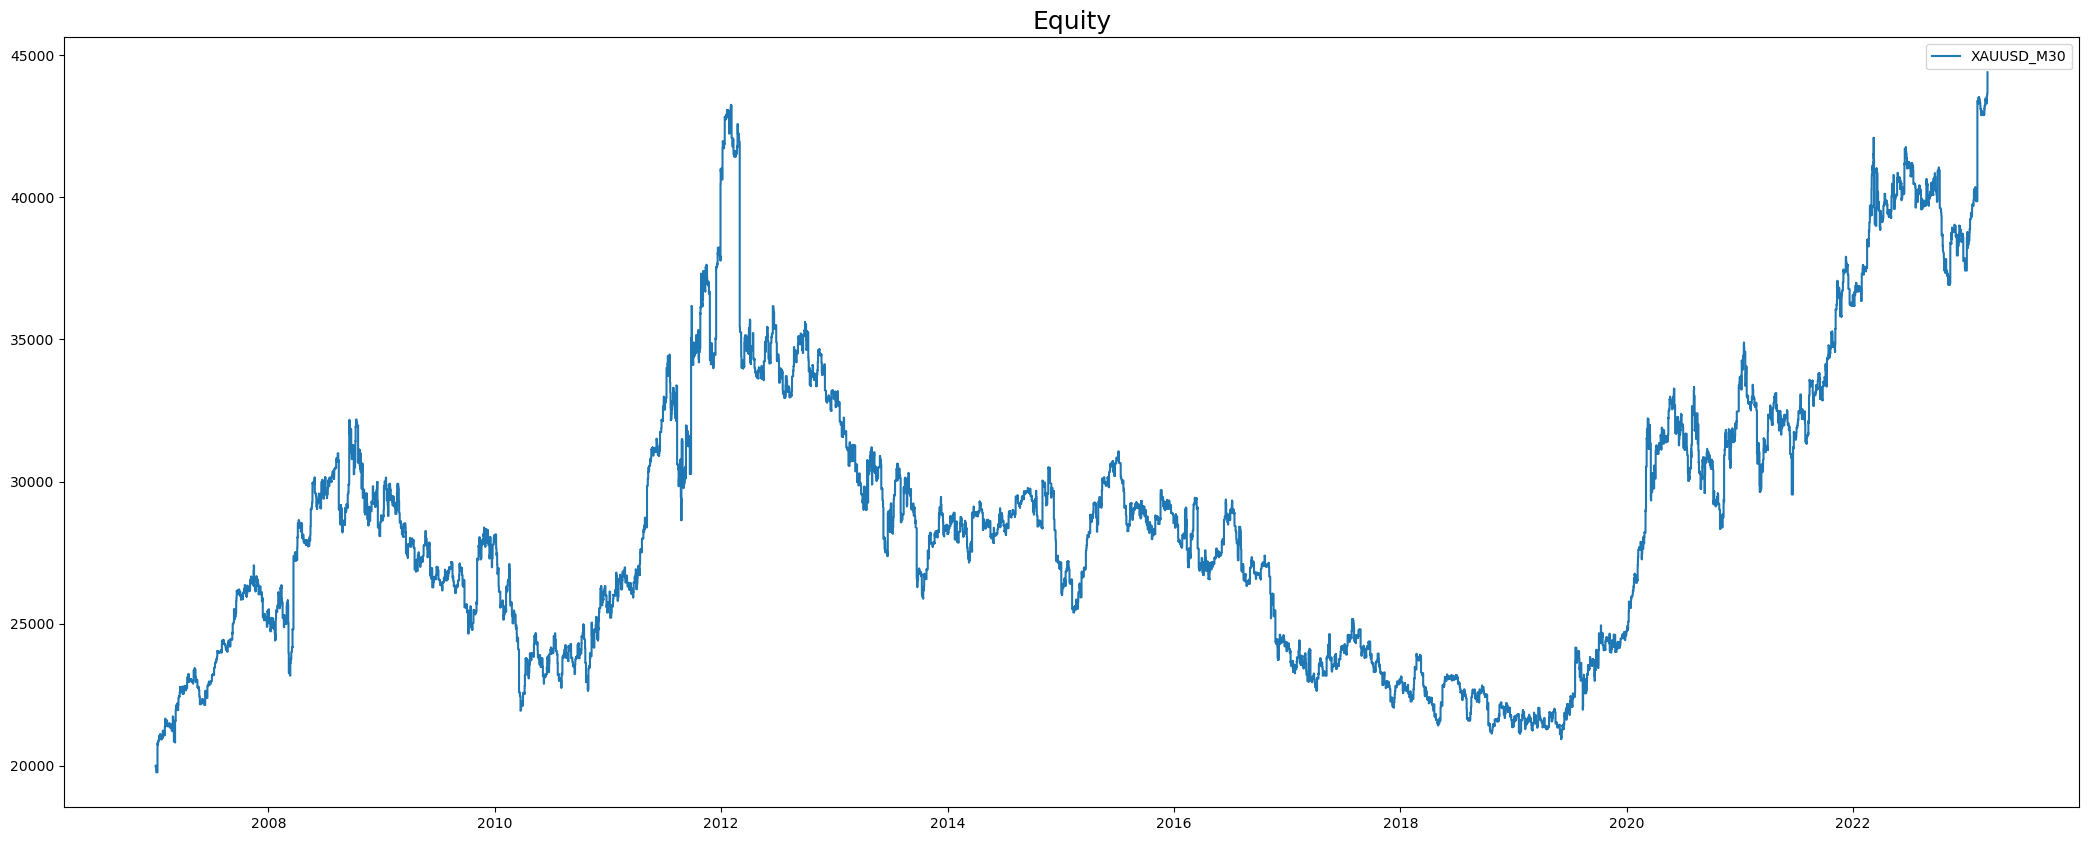

In [9]:
plot_equity_trades(result_M30['_trades'], 'XAUUSD_M30', account_size)

### Save output

In [10]:
# save_to_csv(result_M30, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_M30.csv')  

## TF M15

In [11]:
Backtest_M15 = Backtest(data_M15, strategy,
                       cash=account_size, margin=1/2000, )
result_M15 = Backtest_M15.run()
result_M15

Start                     2014-09-23 16:00:00
End                       2023-03-10 17:45:00
Duration                   3090 days 01:45:00
Exposure Time [%]                    48.15626
Equity Final [$]                          0.0
Equity Peak [$]                     24269.227
Return [%]                             -100.0
Buy & Hold Return [%]               52.466989
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              207.453838
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -5.113613
Max. Drawdown Duration     2804 days 05:45:00
Avg. Drawdown Duration       81 days 07:26:00
# Trades                                59633
Win Rate [%]                        53.002532
Best Trade [%]                       3.894674
Worst Trade [%]                     -3.565267
Avg. Trade [%]                    

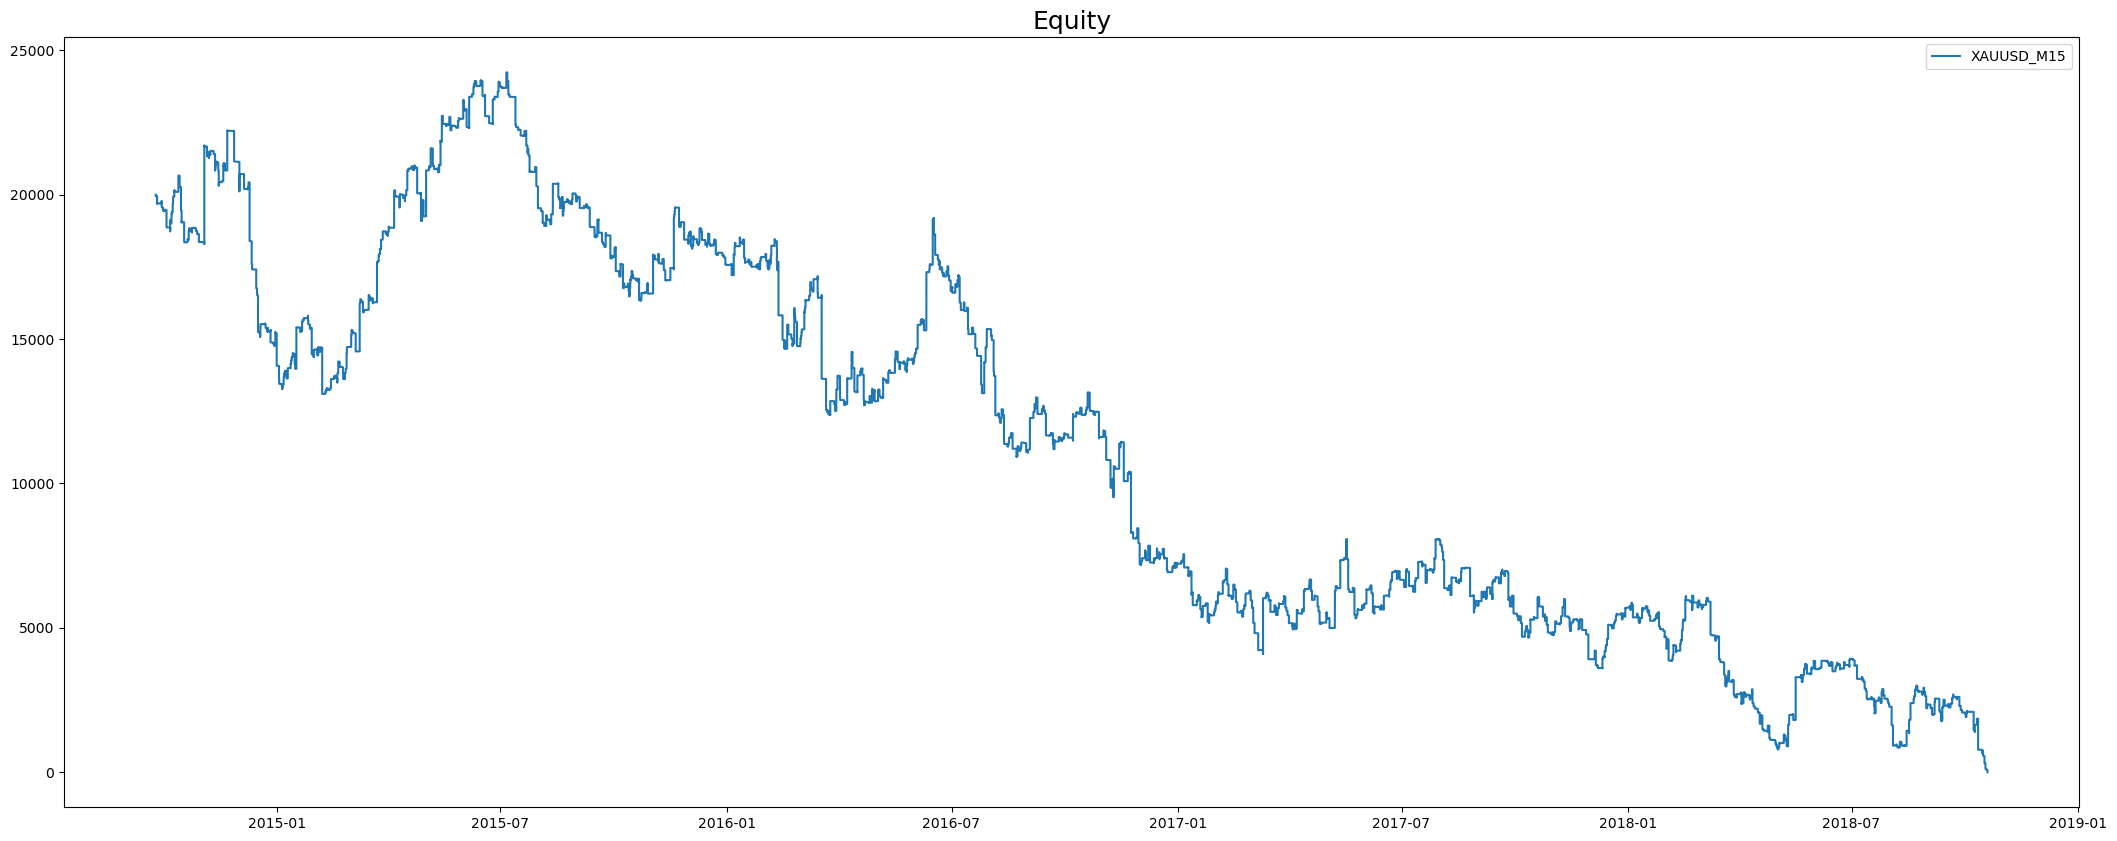

In [12]:
plot_equity_trades(result_M15['_trades'], 'XAUUSD_M15', account_size)

### Save output

In [13]:
# save_to_csv(result_M15, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_M15.csv')  